In [1]:
## Test the performance with different flows
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.metrics import  PIVmetric
from piv_onepass import piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc

np.random.seed(202404)

In [2]:
# Basic functions and the compare cases
def read_flow(path):
    img1 = cv2.imread(path+"_img1.tif", 0)
    img2 = cv2.imread(path+"_img2.tif", 0)
    
    p_flow = path+"_flow.flo"
    flows = np.fromfile(p_flow, dtype=np.float32)
    vec = np.reshape(flows[3:], (256,256,2))
    u, v = vec[:,:,0], vec[:,:,1]
    u, v = np.mean(u), np.mean(v)
    return img1, img2, u, v

def gaussian_noise1(img1, img2):
    mean, sigma = 0, 20
    gaussian = np.random.normal(mean, sigma, img1.shape) #  np.zeros((224, 224), np.float32)

    img1_ = img1+gaussian
    img2_ = img2+gaussian
    # plt.imshow(gaussian, cmap="gray")
    # plt.savefig("gaussian.pdf")
    return img1_, img2_
    
def gaussian_noise2(img1, img2):
    mean, sigma = 0, 20
    gaussian1 = np.random.normal(mean, sigma, img1.shape) #  np.zeros((224, 224), np.float32)
    gaussian2 = np.random.normal(mean, sigma, img1.shape) #  np.zeros((224, 224), np.float32)

    img1_ = img1+gaussian1
    img2_ = img2+gaussian2
    # plt.imshow(gaussian1, cmap="gray")
    # plt.savefig("gaussian1.pdf")
    # plt.figure()
    # plt.imshow(gaussian2, cmap="gray")
    # plt.savefig("gaussian2.pdf")
    return img1_, img2_


def salt_pepper_noise1(img1, img2):
    img1_, img2_ = np.copy(img1), np.copy(img2)
    
    r = np.random.rand(*img1.shape)
    salt_mask = r<0.02
    pepper_mask =  r>0.98

    img1_[salt_mask]=255
    img2_[salt_mask]=255
    img1_[pepper_mask]=0 
    img2_[pepper_mask]=0
    
    # bg = np.ones_like(img1)*128
    # bg[salt_mask]=255
    # bg[pepper_mask]=0 
    # plt.imshow(bg, cmap="gray")
    # plt.savefig("bg.pdf")
    return img1_, img2_

def salt_pepper_noise2(img1, img2):
    img1_, img2_ = np.copy(img1), np.copy(img2)
    
    r1 = np.random.rand(*img1.shape)
    salt_mask1 = r1<0.02
    pepper_mask1 =  r1>0.98

    r2 = np.random.rand(*img1.shape)
    salt_mask2 = r2<0.02
    pepper_mask2 =  r2>0.98


    img1_[salt_mask1]=255
    img2_[salt_mask2]=255
    img1_[pepper_mask1]=0 
    img2_[pepper_mask2]=0

    # bg1 = np.ones_like(img1)*128
    # bg2 = np.ones_like(img1)*128
    # bg1[salt_mask1]=255
    # bg1[pepper_mask1]=0 
    # bg2[salt_mask2]=255
    # bg2[pepper_mask2]=0 
    # plt.imshow(bg1, cmap="gray")
    # plt.savefig("bg1.pdf")
    # plt.figure()
    # plt.imshow(bg2, cmap="gray")
    # plt.savefig("bg2.pdf")

    return img1_, img2_


def exp3_onecase(img1, img2, ut, vt, show=True):        
    if show:
        plt.figure(figsize=(5,3))
        names = ["image1", "image2"]
        for k, img in enumerate([img1, img2]):
            plt.subplot(1,2,k+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(names[k])
        plt.savefig("images.pdf")
        
    if show:
        plt.figure(figsize=(9,6))
        strs = [m.__name__ for m in [piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc]]
        print(f"The results for {strs}")
    
    results =[]
    for k, m in enumerate([piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc]):
        x1,y1,u1,v1 = m(img1, img2)
        if show:
            print(m.__name__+":")
        res = PIVmetric(ut+0*u1,vt+0*v1,u1,v1, show=show)
        results.append(res)
        if show:
            plt.subplot(2,3,k+1)
            plt.quiver(x1,y1,u1,v1) # Without any modification
            plt.title(m.__name__)
    if show:
        plt.show()
    return results

### 0. Test without additive background

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.3753(RMSE)	0.3422(AEE)	0.0438(AAE,rad)	0.2843(SSIM)	0.9459(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3919(RMSE)	0.3438(AEE)	0.0441(AAE,rad)	0.1856(SSIM)	0.9515(MoC)	0(Outlier)	
piv_spof:
0.4060(RMSE)	0.3768(AEE)	0.0504(AAE,rad)	0.2709(SSIM)	0.9439(MoC)	0(Outlier)	
piv_rpc:
0.1883(RMSE)	0.1619(AEE)	0.0231(AAE,rad)	0.3639(SSIM)	0.9951(MoC)	0(Outlier)	
piv_sbcc:
0.2195(RMSE)	0.2050(AEE)	0.0221(AAE,rad)	0.4429(SSIM)	1.0324(MoC)	0(Outlier)	


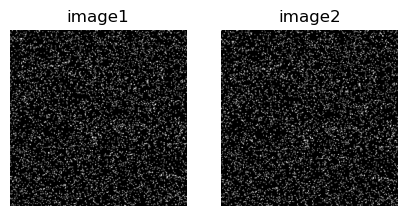

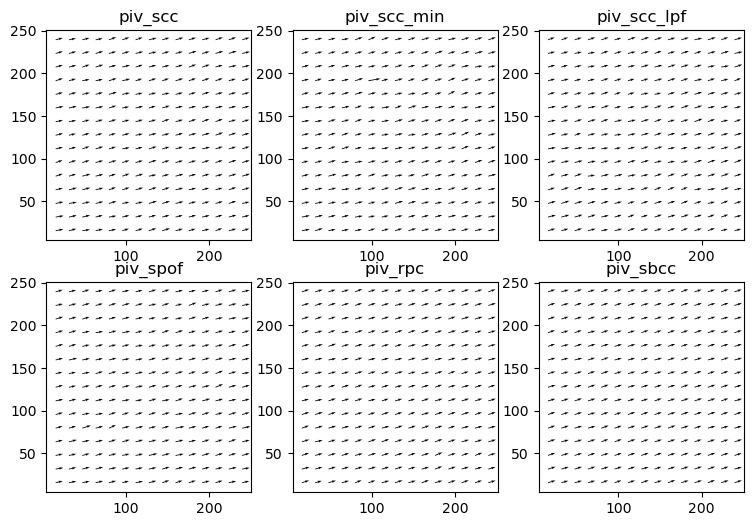

In [3]:
# Test without additive background
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut, vt = read_flow(path)
results = exp3_onecase(img1, img2, vt, ut)

### 1. Test with additive white noise (Gaussian noise)
The noisy images have a shared Gaussian noise

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.3885(RMSE)	0.3503(AEE)	0.0460(AAE,rad)	0.2425(SSIM)	0.9509(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3327(RMSE)	0.3083(AEE)	0.0422(AAE,rad)	0.3776(SSIM)	0.9576(MoC)	0(Outlier)	
piv_spof:
0.4531(RMSE)	0.3952(AEE)	0.0539(AAE,rad)	0.2147(SSIM)	0.9504(MoC)	1(Outlier)	
piv_rpc:
0.2359(RMSE)	0.2065(AEE)	0.0278(AAE,rad)	0.2879(SSIM)	0.9939(MoC)	0(Outlier)	
piv_sbcc:
0.2375(RMSE)	0.2226(AEE)	0.0258(AAE,rad)	0.4309(SSIM)	1.0305(MoC)	0(Outlier)	


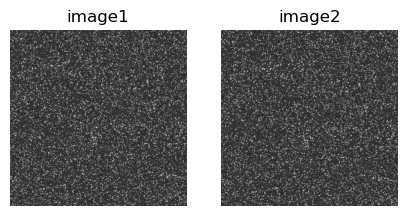

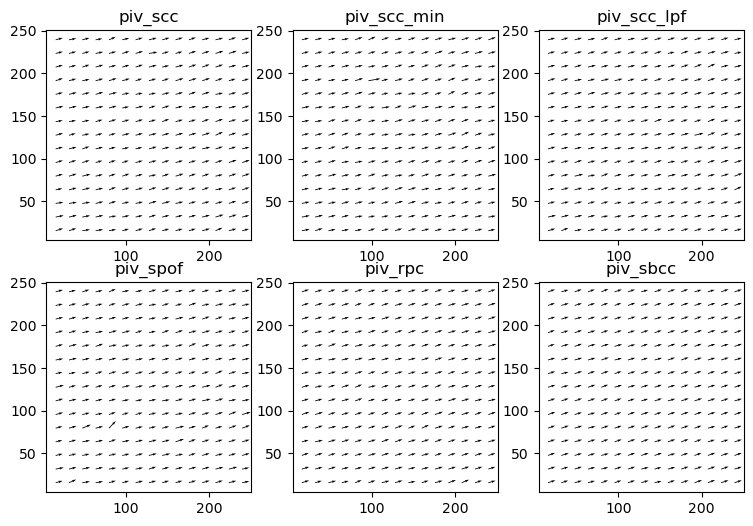

In [4]:
# Test with additive Gaussian noise
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_, img2_ = gaussian_noise1(img1, img2)
results = exp3_onecase(img1_, img2_, vt, ut)

### 2. Test with additive variant white noise (Gaussian noise)
The noisy images have different Gaussian noises

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.3925(RMSE)	0.3564(AEE)	0.0477(AAE,rad)	0.2340(SSIM)	0.9495(MoC)	0(Outlier)	
piv_scc_min:
0.4692(RMSE)	0.4159(AEE)	0.0581(AAE,rad)	0.1616(SSIM)	0.9592(MoC)	1(Outlier)	
piv_scc_lpf:
0.3313(RMSE)	0.3078(AEE)	0.0424(AAE,rad)	0.3445(SSIM)	0.9559(MoC)	0(Outlier)	
piv_spof:
0.4111(RMSE)	0.3776(AEE)	0.0510(AAE,rad)	0.2236(SSIM)	0.9483(MoC)	0(Outlier)	
piv_rpc:
0.2242(RMSE)	0.1965(AEE)	0.0274(AAE,rad)	0.2980(SSIM)	0.9994(MoC)	0(Outlier)	
piv_sbcc:
0.2363(RMSE)	0.2211(AEE)	0.0251(AAE,rad)	0.3763(SSIM)	1.0298(MoC)	0(Outlier)	


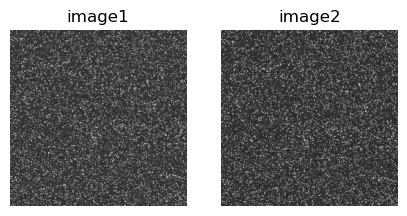

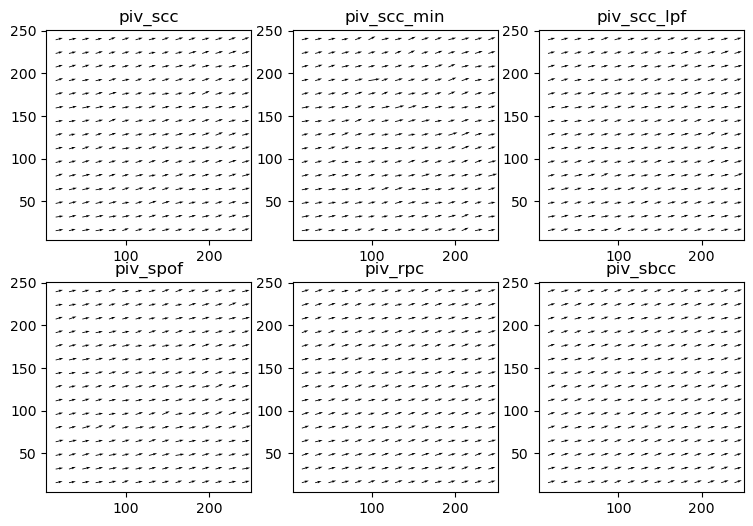

In [5]:
# Test with additive Gaussian noise
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_, img2_ = gaussian_noise2(img1, img2)
results = exp3_onecase(img1_, img2_, vt, ut)

### 3. Test with salt and pepper noise (S&P noise)
The noisy images have a shared S&P noise

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
1.5885(RMSE)	0.8494(AEE)	0.2292(AAE,rad)	0.1292(SSIM)	0.8518(MoC)	23(Outlier)	
piv_scc_min:
0.4464(RMSE)	0.3812(AEE)	0.0535(AAE,rad)	0.2009(SSIM)	0.9559(MoC)	1(Outlier)	
piv_scc_lpf:
0.4604(RMSE)	0.4158(AEE)	0.0526(AAE,rad)	0.1771(SSIM)	0.9384(MoC)	0(Outlier)	
piv_spof:
2.3468(RMSE)	1.3693(AEE)	0.4305(AAE,rad)	0.0710(SSIM)	0.7426(MoC)	47(Outlier)	
piv_rpc:
0.3234(RMSE)	0.2784(AEE)	0.0351(AAE,rad)	0.1768(SSIM)	0.9817(MoC)	0(Outlier)	
piv_sbcc:
0.2664(RMSE)	0.2487(AEE)	0.0293(AAE,rad)	0.2955(SSIM)	1.0255(MoC)	0(Outlier)	


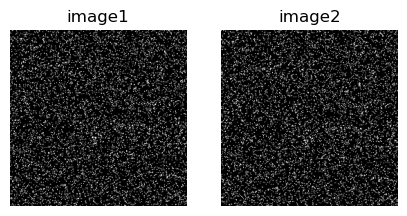

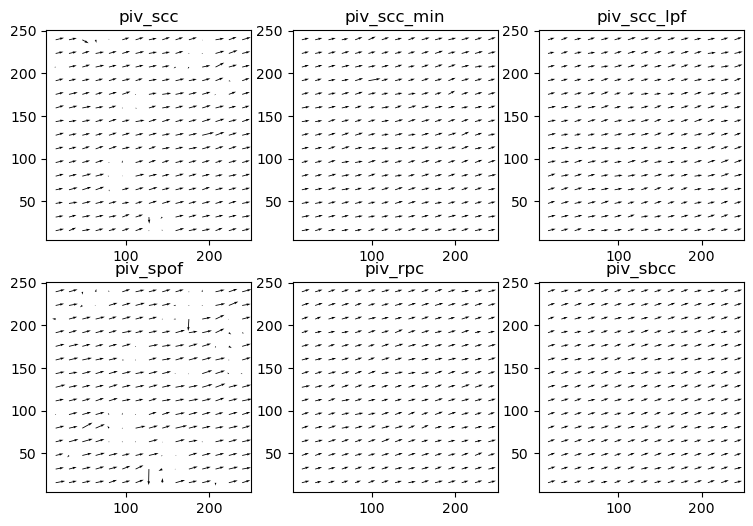

In [6]:
# Test with additive Gaussian noise
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_, img2_ = salt_pepper_noise1(img1, img2)
results = exp3_onecase(img1_, img2_, vt, ut)

### 4. Test with variant salt and pepper noise (S&P noise)
The noisy images have different S&P noises

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.4256(RMSE)	0.3854(AEE)	0.0565(AAE,rad)	0.1934(SSIM)	0.9551(MoC)	0(Outlier)	
piv_scc_min:
0.5631(RMSE)	0.4585(AEE)	0.0690(AAE,rad)	0.1532(SSIM)	0.9697(MoC)	2(Outlier)	
piv_scc_lpf:
0.4718(RMSE)	0.4282(AEE)	0.0573(AAE,rad)	0.1753(SSIM)	0.9342(MoC)	0(Outlier)	
piv_spof:
0.4789(RMSE)	0.4231(AEE)	0.0613(AAE,rad)	0.1598(SSIM)	0.9582(MoC)	0(Outlier)	
piv_rpc:
0.3120(RMSE)	0.2715(AEE)	0.0409(AAE,rad)	0.1968(SSIM)	0.9906(MoC)	0(Outlier)	
piv_sbcc:
0.2819(RMSE)	0.2594(AEE)	0.0354(AAE,rad)	0.2899(SSIM)	1.0212(MoC)	0(Outlier)	


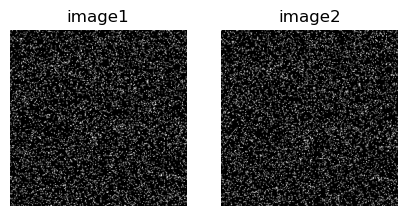

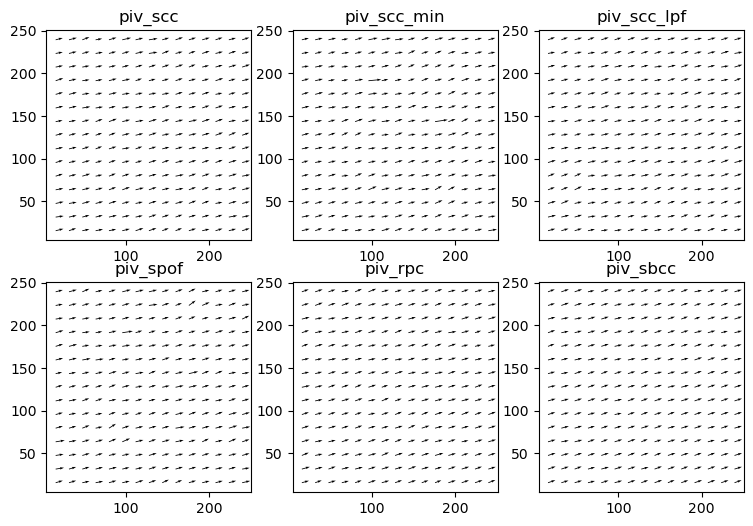

In [7]:
# Test with additive Gaussian noise
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_, img2_ = salt_pepper_noise2(img1, img2)
results = exp3_onecase(img1_, img2_, vt, ut)

### Test for the whole dataset

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.26it/s]


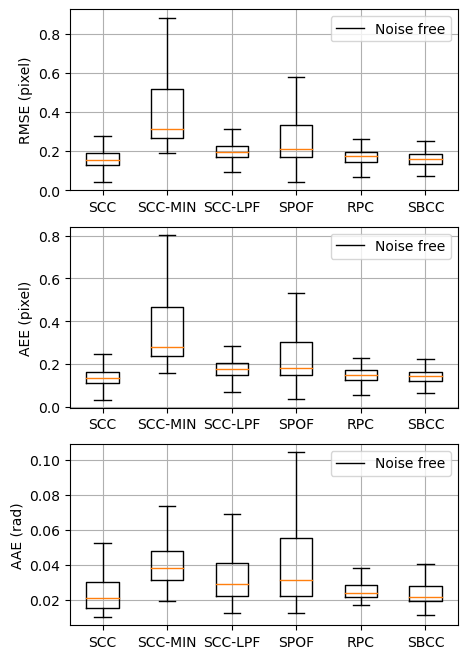

In [8]:
# Num=1001
Num=101 # Less data for test 

names = ["RMSE (pixel)","AEE (pixel)","AAE (rad)","SSIM", "MoC", "Outlier (100%)"]

results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    res = exp3_onecase(img1, img2, vt, ut, show=False)
    results.append(res)
    
results1 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results1[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["Noise free"])
    ax[i].grid("on")
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.43it/s]


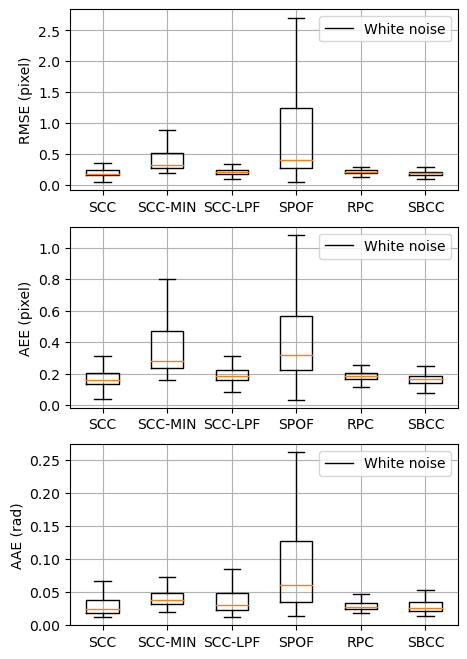

In [9]:
bg_list = os.listdir("./data/simulated/bubbles/Class_1/")

results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    img1_, img2_ = gaussian_noise1(img1, img2)

    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results2 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results2[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["White noise"])
    ax[i].grid("on")
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:43<00:00,  6.10it/s]


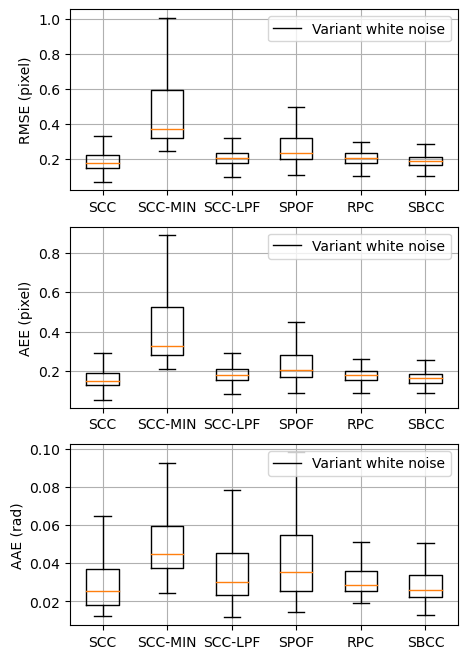

In [10]:
results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)

    img1_, img2_ = gaussian_noise2(img1, img2)

    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results3 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results3[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].grid("on")
    ax[i].legend(["Variant white noise"])
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.25it/s]


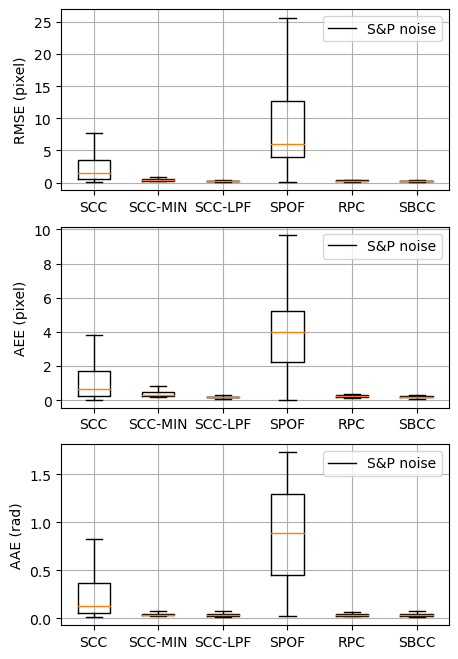

In [11]:
results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    img1_, img2_ = salt_pepper_noise1(img1, img2)

    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results4 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results4[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["S&P noise"])
    ax[i].grid("on")
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:41<00:00,  6.18it/s]


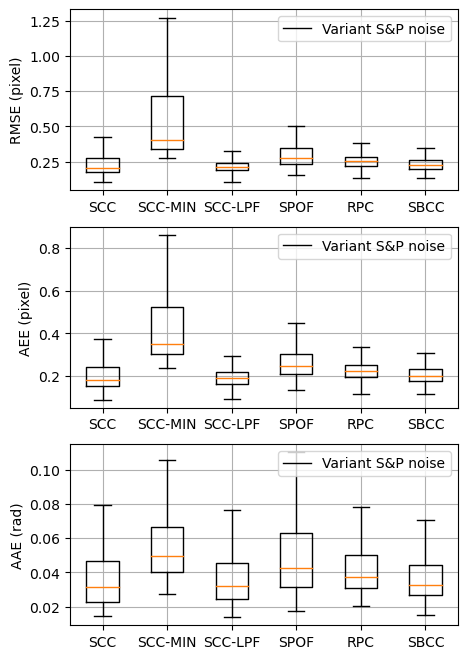

In [12]:
results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    img1_, img2_ = salt_pepper_noise2(img1, img2)

    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results5 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results5[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["Variant S&P noise"])
    ax[i].grid("on")
plt.show()

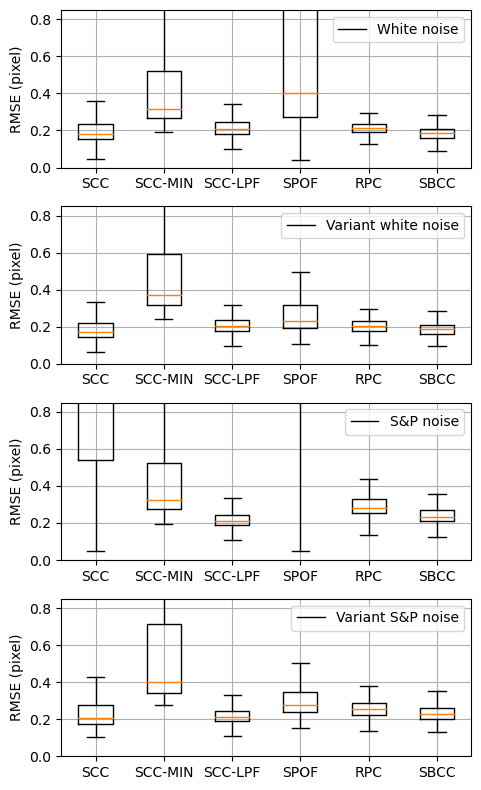

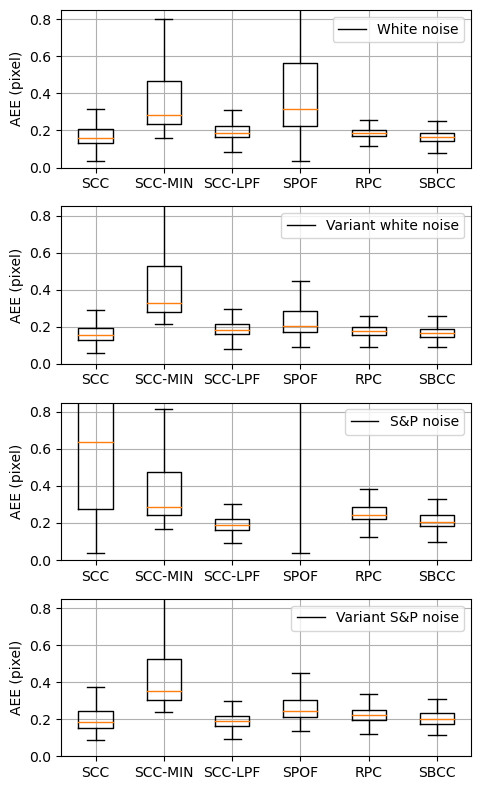

In [13]:
names = ["RMSE (pixel)","AEE (pixel)","AAE (rad)","SSIM", "MoC", "Outlier (100%)"]
legends = ["White noise","Variant white noise","S&P noise", "Variant S&P noise"]

for k in range(2):
    fig, ax = plt.subplots(4,1, figsize=(5, 8)) 
    for i, result in enumerate([results2, results3,results4,results5]):
        ax[i].boxplot(result[:,:,k], showfliers=False)
        ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
        ax[i].set_ylabel(names[k])
        ax[i].legend([legends[i]], loc=1)
        ax[i].grid("on")
        ax[i].axis(ymin=0.00,ymax=0.85)
    plt.tight_layout()
    plt.savefig(f"./data/output/Fig9_{k}.pdf")
plt.show()

In [14]:
# T tests for the results
from scipy.stats import ttest_ind, ttest_rel

# p values for RMSE
for k, result in enumerate([results2, results3,results4, results5]):
    print(legends[k])
    for ind in range(6):
        # res = ttest_ind(result[:,ind,0],result[:,-1,0],alternative='greater')
        res = ttest_rel(result[:,ind,0],result[:,-1,0],alternative='greater')
        print(f"{res.pvalue:.4g}")

White noise
5.975e-14
7.769e-35
1.296e-46
6.59e-11
2.634e-64
nan
Variant white noise
0.02306
2.866e-25
1.332e-52
1.426e-27
2.297e-65
nan
S&P noise
7.276e-05
4.196e-17
0.9332
0.0596
3.835e-09
nan
Variant S&P noise
0.0632
1.727e-08
0.9678
1.26e-05
2.014e-23
nan


In [15]:
# p values for AEE
for k, result in enumerate([results2, results3,results4, results5]):
    print(legends[k])
    for ind in range(6):
        res = ttest_rel(result[:,ind,1],result[:,-1,1],alternative='greater')
        print(f"{res.pvalue:.4g}")

White noise
3.002e-13
7.577e-64
5.491e-60
3.989e-29
4.044e-116
nan
Variant white noise
0.09356
1.43e-39
7.264e-59
9.232e-124
3.006e-54
nan
S&P noise
1.353e-16
3.044e-42
1
0.01436
3.023e-119
nan
Variant S&P noise
0.4324
6.789e-22
0.9999
2.019e-63
1.407e-81
nan
